# 1> Importing Necessary Libraries

In [1]:
#Importing Torch libraries
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.0+cpu
torchvision version: 0.20.0+cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print(f"[INFO] Installing torch info")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  print("1")
  from going_modular import data_setup,engine
  from going_modular.helper_functions import download_data,set_seeds,plot_loss_curves
except:
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
  ! git clone https://github.com/mrdbourke/pytorch-deep-learning
  ! mv pytorch-deep-learning/going_modular .
  ! mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  ! rm -rf pytorch-deep-learning
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

1


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2> Device Agnostic Code

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


# 3> Get Data

In [4]:
image_path=download_data(source="https://github.com/HarshEkbote/PyTorch-Basics/raw/main/data/pizza_steak_sushi.zip",destination="pizza_steak_sushi")

image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
train_dir=image_path/"train"
test_dir=image_path/"test"

# 4> Create Dataloaders

In [6]:
#Create transformations
IMG_SIZE=224

manual_transforms=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manual Transforms: {manual_transforms}")

Manual Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
#Set the batch size
BATCH_SIZE=32    # The batch size is 4096 for the original paper but as our data is small and we use a single GPU we take batch size of 32

#Create Dataloader
train_dataloader,test_dataloader,class_names=data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c7dcd1efe0>,
 ['pizza', 'steak', 'sushi'])

torch.Size([3, 224, 224]) tensor(1)


(-0.5, 223.5, 223.5, -0.5)

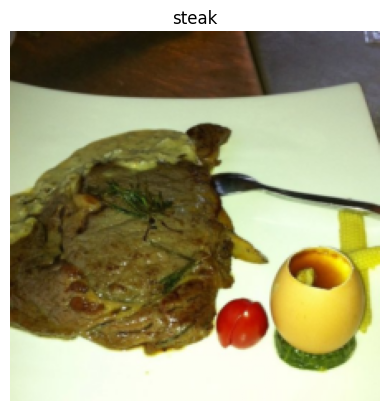

In [8]:
#Visualize the image

#Get the batch of the image
image_batch,label_batch=next(iter(train_dataloader))

#Get the single image from the batch
image,label=image_batch[0],label_batch[0]

print(image.shape,label)

#Plot the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

*Implementing the 4 main equation fot Vit-Base*

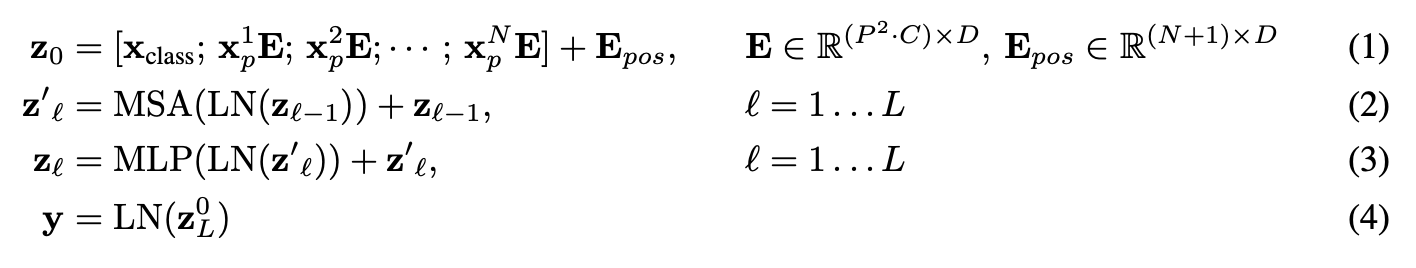

## Equation 1 consists of the following:

1. Divide the image into patches and convert it to embeddings.
2. Create embedding for the class token.
3. Position embedding for each patch.

# 5> Equation 1: Split data into patches and creating the class, position and patch embedding

- Number of patches (N)= (height*width)/ (patch_size^2)
- The image gets converted to a sequence of flattened 2D patches with size (N , P^2 *C)


In [9]:
#creating example values
height=224  #H
width=224 #W
channels=3  #C
patch_size=16 #P

#finding the number of patches for the image size (224,224,3)
number_of_patches=int((height*width)/patch_size**2)
print(f"Number of patches (N) with image (H={height}, W={width}, C={channels} and P={patch_size}): {number_of_patches}")

Number of patches (N) with image (H=224, W=224, C=3 and P=16): 196


In [10]:
#Input shape of the image
embedding_layer_input_shape=(height,width,channels)

#Output shape
embedding_layer_output_shape=(number_of_patches,patch_size**2*channels)
print(f"Input shape: {embedding_layer_input_shape}")
print(f"Output shape: {embedding_layer_output_shape}")

Input shape: (224, 224, 3)
Output shape: (196, 768)


## 5.1> Turning a single image to patches ( manually )

(-0.5, 223.5, 223.5, -0.5)

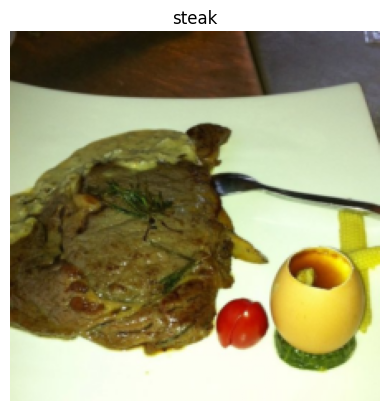

In [11]:
#plotting an image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

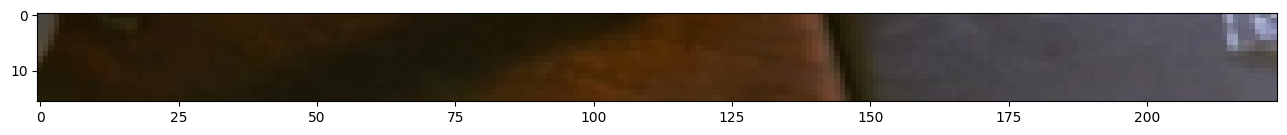

In [12]:
#change image shape to a compatiable with matplotlib
image_permuted=image.permute(1,2,0)

#index to plot the top row of the patches pixels
patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch Size: 16 pixels x 16 pixels


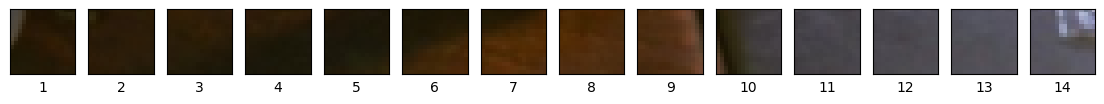

In [13]:
#Patch for only the first row in the image

#setup hyperparameters and make sure img_size and input_size are compatiable
img_size=224
patch_size=16
number_patches=img_size/patch_size
assert img_size%patch_size==0
print(f"Number of patches per row: {number_patches}\nPatch Size: {patch_size} pixels x {patch_size} pixels")

#create a series of subplots
fig,axes=plt.subplots(nrows=1,
                     ncols=img_size//patch_size,
                     figsize=(number_patches,number_patches),
                     sharex=True,
                     sharey=True)

for i, patch in enumerate(range(0,img_size,patch_size)):
  axes[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


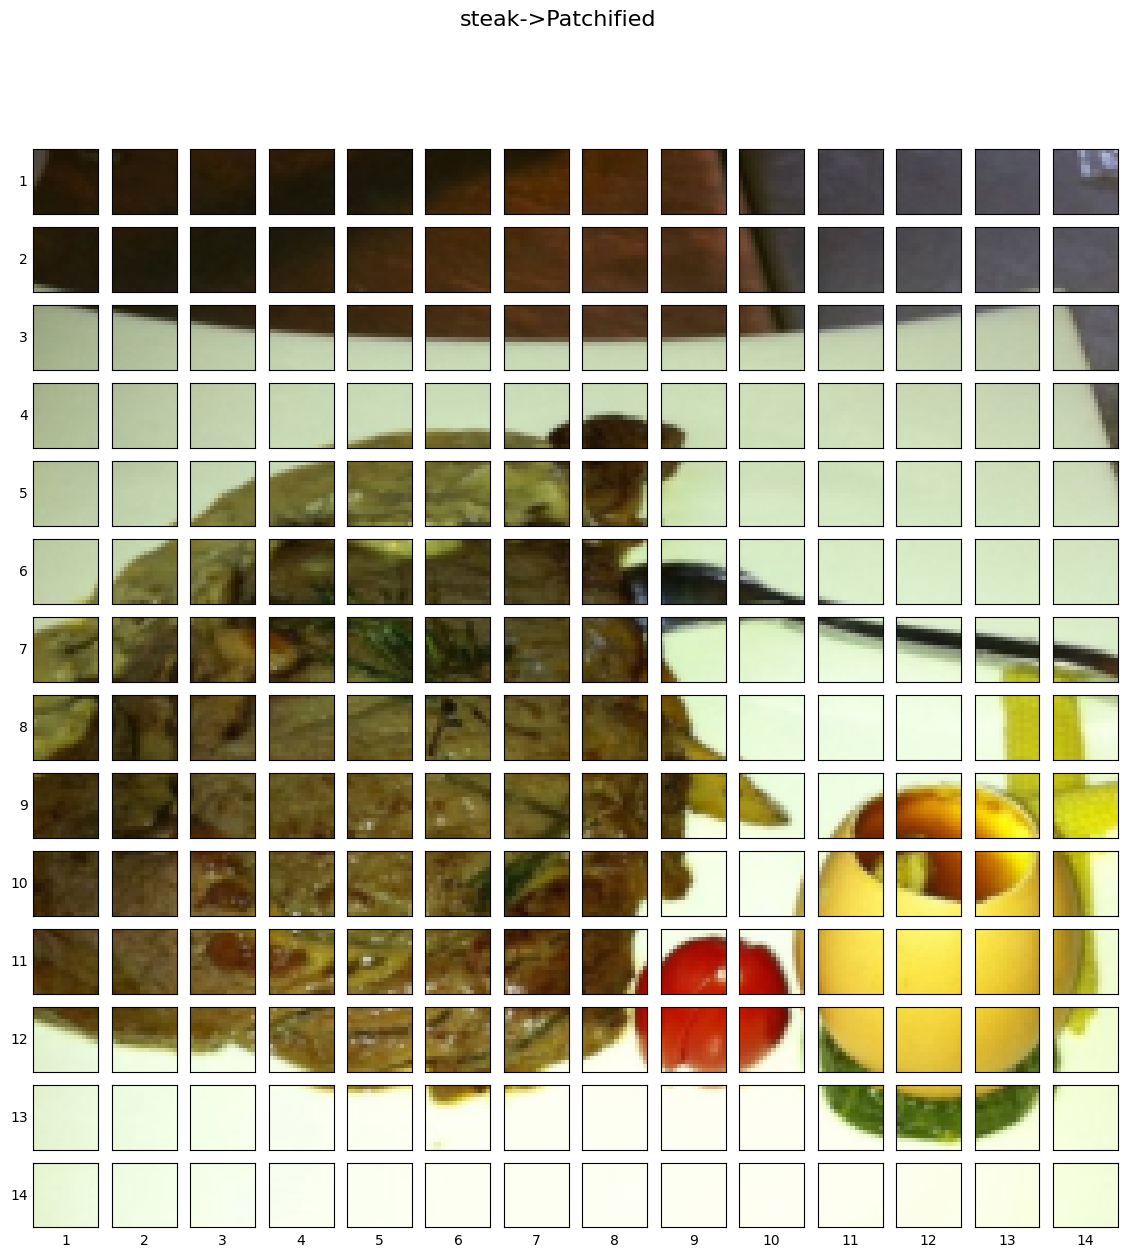

In [14]:
#Patch for the whole image

img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig,axs=plt.subplots(nrows=img_size//patch_size,
                     ncols=img_size//patch_size,
                     figsize=(num_patches,num_patches),
                     sharex=True,
                     sharey=True)

for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):

    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])

    axs[i,j].set_ylabel(i+1,rotation="horizontal",horizontalalignment="right",verticalalignment="center")

    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

#Set super title
fig.suptitle(f"{class_names[label]}->Patchified", fontsize=16)
plt.show()

## 5.2> Creating Patches and embeddings using the Conv2d and flatten fucntions

In [15]:
from torch import nn

#set the patch_size=16
patch_size=16

#create the conv2d layer with hyperparameters from the ViT paper
conv2d=nn.Conv2d(in_channels=3,
                 out_channels=768,
                 kernel_size=patch_size,
                 stride=patch_size,padding=0)

#pass the image through the conv layer
image_out_of_conv=conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)  #[batch_size,embeddings_dim,feature_map_height,feature_map_width]

torch.Size([1, 768, 14, 14])


The random convolutional fetaire maps from index: [574, 163, 728, 270, 755]


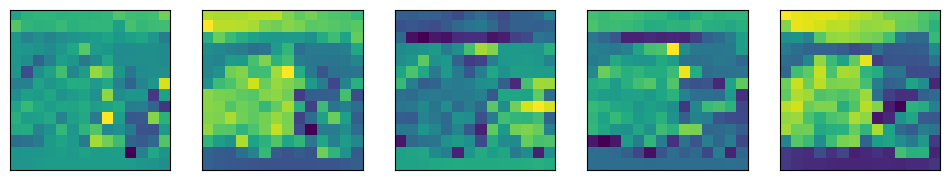

In [16]:
#Visualize random 5 patches
import random
random_index=random.sample(range(0,758),k=5)
print(f"The random convolutional fetaire maps from index: {random_index}")

fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i,idx in enumerate(random_index):
  image_conv_feature_map=image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [17]:
#get a single feature map in tensor form
single_feature_map=image_out_of_conv[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[ 5.9005e-02, -7.5765e-03, -4.7461e-03,  4.4404e-04, -2.1277e-02,
           -1.0226e-03,  1.8225e-02,  2.1271e-02,  4.5853e-02, -8.2156e-02,
           -8.7451e-02, -9.5171e-02, -1.0288e-01, -1.4117e-01],
          [-1.1756e-01, -1.9092e-02, -1.9573e-02, -1.4220e-02, -2.4639e-03,
            1.2711e-02,  1.9098e-02,  1.6233e-02,  4.0257e-02, -9.2379e-03,
           -1.0750e-01, -1.1601e-01, -1.1656e-01, -1.3366e-01],
          [-6.5463e-02, -2.0075e-01, -2.2156e-01, -2.5392e-01, -3.2634e-01,
           -3.8759e-01, -4.0591e-01, -4.0208e-01, -3.4324e-01, -3.1762e-01,
           -3.5951e-01, -1.8998e-01, -1.3904e-01, -1.3413e-01],
          [-1.1800e-01, -1.3148e-01, -1.4085e-01, -1.4292e-01, -5.5434e-02,
            1.5412e-01, -1.9621e-02,  2.0658e-01,  2.4747e-01, -1.4172e-01,
           -1.4782e-01, -1.6625e-01, -1.6167e-01, -2.7313e-01],
          [-1.2906e-01, -1.3886e-01,  6.6892e-02, -3.0601e-02, -1.1086e-02,
           -3.4276e-02,  9.6824e-02,  2.9226e-02, -1.9162e-0

In [18]:
#Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape}") # we need a shape of (768,196)

Current tensor shape: torch.Size([1, 768, 14, 14])


In [19]:
#create flatten layer
flatten=nn.Flatten(start_dim=2, #flatten feature_map_height (dimension 2)
                   end_dim=3)   #flatten feature_map_width  (dimension 3)

## 5.3> Patch the image and convert to emebeddings
1. Take a single image
2. Put in through the conv layer to turn the image into 2D feature map (patch embeddings)
3. Flatten the 2D feature map into a single sequence

Desired output shape is (196,768)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape :torch.Size([1, 768, 14, 14])
Feature image deature map shape (after flatten): torch.Size([1, 768, 196])


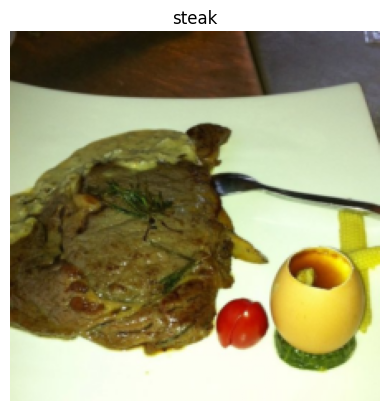

In [20]:
#1. View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

#2. Turn image into feature map
image_out_of_conv=conv2d(image.unsqueeze(0))
print(f"Image feature map shape :{image_out_of_conv.shape}")

#Flatten the feature map
image_flatten=flatten(image_out_of_conv)
print(f"Feature image deature map shape (after flatten): {image_flatten.shape}")

In [21]:
# Putting it to the right shape
image_flat_reshape=image_flatten.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_flat_reshape.shape}->[batch_size,num_patches,embeddings_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768])->[batch_size,num_patches,embeddings_size]


(-0.5, 195.5, 0.5, -0.5)

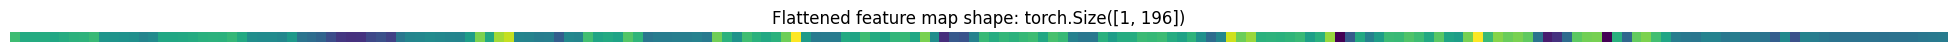

In [22]:
#Visualize te flatten feature map
single_flattened_feature_map=image_flat_reshape[:,:,0]

plt.figure(figsize=(25,25))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [23]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 5.9005e-02, -7.5765e-03, -4.7461e-03,  4.4404e-04, -2.1277e-02,
          -1.0226e-03,  1.8225e-02,  2.1271e-02,  4.5853e-02, -8.2156e-02,
          -8.7451e-02, -9.5171e-02, -1.0288e-01, -1.4117e-01, -1.1756e-01,
          -1.9092e-02, -1.9573e-02, -1.4220e-02, -2.4639e-03,  1.2711e-02,
           1.9098e-02,  1.6233e-02,  4.0257e-02, -9.2379e-03, -1.0750e-01,
          -1.1601e-01, -1.1656e-01, -1.3366e-01, -6.5463e-02, -2.0075e-01,
          -2.2156e-01, -2.5392e-01, -3.2634e-01, -3.8759e-01, -4.0591e-01,
          -4.0208e-01, -3.4324e-01, -3.1762e-01, -3.5951e-01, -1.8998e-01,
          -1.3904e-01, -1.3413e-01, -1.1800e-01, -1.3148e-01, -1.4085e-01,
          -1.4292e-01, -5.5434e-02,  1.5412e-01, -1.9621e-02,  2.0658e-01,
           2.4747e-01, -1.4172e-01, -1.4782e-01, -1.6625e-01, -1.6167e-01,
          -2.7313e-01, -1.2906e-01, -1.3886e-01,  6.6892e-02, -3.0601e-02,
          -1.1086e-02, -3.4276e-02,  9.6824e-02,  2.9226e-02, -1.9162e-01,
          -1.6940e-01, -1

## 5.4> Creating a module for the Patch and embedding layer

In [24]:
#1. creating a class
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
  def __init__(self,in_channels:int=3,patch_size:int=16,embedding_size=768):
    super().__init__()

    self.patcher=nn.Conv2d(in_channels=in_channels,out_channels=embedding_size,kernel_size=patch_size,stride=patch_size,padding=0) #layer to turn images to patches

    self.flatten=nn.Flatten(start_dim=2,end_dim=3) #layer to flatten the patch feature maps in single dimension

  def forward(self,x):
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size==0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

  #perform forward pass
    x_patched=self.patcher(x) #make patches for image
    x_flatten=self.flatten(x_patched) #flatten the patches
    return x_flatten.permute(0,2,1) #adjust the shape to (batch_size, N,P^2 * C)

In [25]:
set_seeds()

patchify=PatchEmbedding(in_channels=3,patch_size=16,embedding_size=768)

#pass image through it
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image=patchify(image.unsqueeze(0))
print(f"Output shape of embeddings: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output shape of embeddings: torch.Size([1, 196, 768])


In [26]:
#Summary for the PatchEmbedding Layer

# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 5.5> Creating the class token embeddings

**Note**: Using torch.ones() to create the learnable class token is mostly for demonstration purposes only, in practice, you'd likely create it with torch.randn().

In [27]:
#Printing the patchembeddings and its shape

print(patch_embedded_image)
print(f"\nThe shape of patch embeddings: {patch_embedded_image.shape}") #[batch size, number of patches, embedding dimensions]

tensor([[[-0.0923, -0.0183, -0.0100,  ...,  0.0744, -0.1433,  0.0268],
         [-0.1353,  0.0040, -0.0340,  ...,  0.0698, -0.0644,  0.0383],
         [-0.1324,  0.0205, -0.0535,  ...,  0.0793, -0.0622,  0.0442],
         ...,
         [-1.0148,  0.2760, -0.2805,  ...,  0.7731, -0.4707,  0.3622],
         [-1.0130,  0.2678, -0.2796,  ...,  0.7709, -0.4691,  0.3620],
         [-0.9858,  0.2744, -0.2855,  ...,  0.7528, -0.4589,  0.3583]]],
       grad_fn=<PermuteBackward0>)

The shape of patch embeddings: torch.Size([1, 196, 768])


In [28]:
#Creating a class token with shape [batch size,1,embedding size]

batch_size=patch_embedded_image.shape[0]
embedding_size=patch_embedded_image.shape[-1]

class_token=nn.Parameter(torch.ones(batch_size,1,embedding_size),requires_grad=True)

print(class_token[:,:,:10])

print(f"class token shape is :{class_token.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class token shape is :torch.Size([1, 1, 768])


In [29]:
#Add the class token to front of the patch embeddings
patch_embedded_image_with_class_token=torch.cat((class_token,patch_embedded_image),dim=1)

print(patch_embedded_image_with_class_token)
print(f"Shape of the embedding after we concat the class token :{patch_embedded_image_with_class_token.shape}") #[batch size, number of patches,embedding size]

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0923, -0.0183, -0.0100,  ...,  0.0744, -0.1433,  0.0268],
         [-0.1353,  0.0040, -0.0340,  ...,  0.0698, -0.0644,  0.0383],
         ...,
         [-1.0148,  0.2760, -0.2805,  ...,  0.7731, -0.4707,  0.3622],
         [-1.0130,  0.2678, -0.2796,  ...,  0.7709, -0.4691,  0.3620],
         [-0.9858,  0.2744, -0.2855,  ...,  0.7528, -0.4589,  0.3583]]],
       grad_fn=<CatBackward0>)
Shape of the embedding after we concat the class token :torch.Size([1, 197, 768])


## 5.6> Position embeddings

The size of the position embeddings is (N+1)*D

where N=(H*W)/P^2, number of patches
      
  D is the size of patch embeddings


**Note: Only creating the position embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the position embedding with torch.randn() (start with a random number and improve via gradient descent).**

In [30]:
number_of_patches=int((height*width)/patch_size**2) #Calculate N
embedding_dim=patch_embedded_image_with_class_token.shape[2] #embedding dimension

position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dim),requires_grad=True)  #creating the position emebdding parameter

print(position_embedding)
print(f"Postion embedding shape: {position_embedding.shape}")

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)
Postion embedding shape: torch.Size([1, 197, 768])


In [31]:
#Add theposition embeddings to the patch embeddings
patch_and_position_embedding=patch_embedded_image_with_class_token+position_embedding

print(patch_and_position_embedding)
print(f"Shape of the embedding with position info is: {patch_and_position_embedding.shape}")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.9077,  0.9817,  0.9900,  ...,  1.0744,  0.8567,  1.0268],
         [ 0.8647,  1.0040,  0.9660,  ...,  1.0698,  0.9356,  1.0383],
         ...,
         [-0.0148,  1.2760,  0.7195,  ...,  1.7731,  0.5293,  1.3622],
         [-0.0130,  1.2678,  0.7204,  ...,  1.7709,  0.5309,  1.3620],
         [ 0.0142,  1.2744,  0.7145,  ...,  1.7528,  0.5411,  1.3583]]],
       grad_fn=<AddBackward0>)
Shape of the embedding with position info is: torch.Size([1, 197, 768])


## 5.7> Putting it all together (Equation 1)

In [32]:
set_seeds()

#1. define the patch size
patch_size=16

#2. print shape of original image tensor and get the image dimension
print(f"Image tensor shape: {image.shape}")
height,width=image.shape[1],image.shape[2]

#3. get the image tensor and add the batch dimension
x=image.unsqueeze(0)
print(f"Input image with the batch dimension has shape: {x.shape}")

#4. create patch embedding layer
patch_embedding_layer=PatchEmbedding(in_channels=3,patch_size=16,embedding_size=768)

#5. Pass image through the patch embedding layer
patch_embedding=patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

#6. Create class token embedding
batch_size=patch_embedding.shape[0]
embedding_dimension=patch_embedding.shape[-1]
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f"The class token embedding shape is: {class_token.shape}")

#7. Prepend the class token embedding tothe patch embedding
patch_embedding_class_token=torch.cat((class_token,patch_embedding),dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

#8. Create position embeddings
number_of_patches=int((height*width)/patch_size**2)
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)

#Appnend the position embedding to the patch embedding
patch_and_position_embedding=patch_embedding_class_token+position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with the batch dimension has shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
The class token embedding shape is: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 6> Equation 2: Multi-Head Self Attention (MSA block)

Consists of :
1. Multi-head self attention layer
2. Normalization layer
3. Residual Connection (included when we create the transformer encoder)

In [33]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self,embedding_dim:int=768,num_heads:int=12,attn_dropout:float=0):
    super().__init__()

    #Normalization layer
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    #Multi-head Self Attention layer
    self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,
                                              num_heads=num_heads,
                                              dropout=attn_dropout,
                                              batch_first=True)

  def forward(self,x):
    x=self.layer_norm(x)
    attn_output,_=self.multihead_attn(query=x, #query embeddings
                                      key=x,  #key embeddings
                                      value=x,  #value embeddings
                                      need_weights=False) #do we need the weights or just layer outputs

    return attn_output

In [34]:
#Trying out the MSA block
MSA_block=MultiHeadAttentionBlock(embedding_dim=768,num_heads=12)

patched_image_through_msa_block=MSA_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# 7> Equation 3: Multilayer perceptron (MLP)

In [35]:
class MLPBlock(nn.Module):
  def __init__(self,embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    #create the norm layer
    self.norm_layer=nn.LayerNorm(normalized_shape=embedding_dim)

    #create the multi layer perceptron
    self.mlp=nn.Sequential(
        nn.Linear(in_features=embedding_dim,out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x=self.norm_layer(x)
    x=self.mlp(x)
    return x

In [36]:
#Trying out the MLP block
mlp_block=MLPBlock(embedding_dim=768,mlp_size=3072,dropout=0.1)

patched_image_through_mlp_block=mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# 8> Creating Transformer Encoder

## 8.1> Manually

In [37]:
class TransformerEncoder(nn.Module):
  def __init__(self,embedding_dim:int=768,num_head:int=12,mlp_size:int=3072,mlp_dropout:float=0.1,attn_dropout:float=0):
    super().__init__()

    self.msa_block=MultiHeadAttentionBlock(embedding_dim=embedding_dim,num_heads=num_head,attn_dropout=attn_dropout)

    self.mlp_block=MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)

  def forward(self,x):
    x=self.msa_block(x)+x
    x=self.mlp_block(x)+x
    return x

In [38]:
#Create the instance of transformer encoder block
transformer_encoder_block=TransformerEncoder()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttentionBlock (msa_block)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## 8.2> Using Pytorch layers

In [39]:
#Creating the Transformer Encoder with Pytorch Transformer layer
torch_transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=768, #Hidden size D
                                                           nhead=12, #heads for ViT-Base
                                                           dim_feedforward=3072,#MLP size
                                                           dropout=0.1,#Amount of dropout for dense layer
                                                           activation="gelu", #GELU non linear activation function
                                                           batch_first=True, #Do batches come first
                                                           norm_first=True )#Normalize first or after MSA?MLP layers?
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [40]:
# Get the output of PyTorch's version of the Transformer Encoder
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

# 9> Creating the ViT

In [41]:
#1. Creat e class ViT that inherits the nn.Module
class ViT(nn.Module):
  #2. Initialize the class with hyperparameters
  def __init__(self,img_size:int=224,in_channels:int=3,patch_size:int=16,num_transformer_layer:int=12,embedding_dim:int=768,mlp_size:int=3072,num_heads:int=12,attn_dropout:float=0,mlp_dropout:float=0.1,embedding_dropout:float=0.1,num_classes:int=1000):
    super().__init__()

    #3. Check if image size is divisible by the patch size
    assert img_size%patch_size==0,f"Image size must be divisible by patch size"

    #4. Calculate the number of patches (height*width)/patch_size^2
    self.num_patches=(img_size*img_size)//patch_size**2

    #5. create learnable class embedding (front of patch embedding)
    self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)

    #6.Create learnable position embedding
    self.position_embedding=nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),requires_grad=True)

    #7. Create embedding dropout value
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    #8. Create the patch embedding
    self.patch_embedding=PatchEmbedding(in_channels=3,patch_size=patch_size,embedding_size=embedding_size)

    #9. Create Transformer Encoding block
    self.transformer_encoder=nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,num_head=num_heads,mlp_size=mlp_size,mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)])

    #10. Create classifier head
    self.classifier=nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,out_features=num_classes)
    )

  #11. Create the forward method
  def forward(self,x):
    #12. Get the batch size
    batch_size=x.shape[0]

    #13. Create class token embedding and expand it to match the batch size
    class_token=self.class_embedding.expand(batch_size,-1,-1)

    #14. Create the patch embedding
    x=self.patch_embedding(x)

    #15. Concat the class embedding to the patch embeddings
    x=torch.cat((class_token,x),dim=1)

    #16. Add the position embedding to the patch embedding
    x=self.position_embedding+x

    #17. Run embedding dropout
    x=self.embedding_dropout(x)

    #18. Pass patch,position and class embedding through transformer encoder layer
    x=self.transformer_encoder(x)

    #19. Put 0 index logit through the classifier
    x=self.classifier(x[:,0])

    return x

In [42]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [43]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [44]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoder (0)                                [32, 197, 768]       [32, 197, 768]

# 10> Training the model

In [46]:
from going_modular import engine

optimizer=torch.optim.Adam(params=vit.parameters(),lr=3e-3,betas=(0.9,0.999),weight_decay=0.3)

loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()

#Train the model and save the training resultsto dictionary
results=engine.train(model=vit,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=20,
                     device=device)

  5%|▌         | 1/20 [06:37<2:05:47, 397.22s/it]

Epoch: 1 | train_loss: 5.1311 |train_acc: 0.34 | test_loss: 4.9150 | test_acc: 0.26


 10%|█         | 2/20 [14:07<2:08:32, 428.46s/it]

Epoch: 2 | train_loss: 1.7756 |train_acc: 0.29 | test_loss: 2.0910 | test_acc: 0.26


 15%|█▌        | 3/20 [20:27<1:55:06, 406.28s/it]

Epoch: 3 | train_loss: 1.3007 |train_acc: 0.37 | test_loss: 1.4524 | test_acc: 0.26


 20%|██        | 4/20 [25:00<1:34:17, 353.61s/it]

Epoch: 4 | train_loss: 1.1873 |train_acc: 0.29 | test_loss: 1.2430 | test_acc: 0.26


 25%|██▌       | 5/20 [28:54<1:17:40, 310.68s/it]

Epoch: 5 | train_loss: 1.1479 |train_acc: 0.42 | test_loss: 1.0052 | test_acc: 0.54


 30%|███       | 6/20 [32:43<1:06:01, 282.93s/it]

Epoch: 6 | train_loss: 1.1476 |train_acc: 0.43 | test_loss: 1.3913 | test_acc: 0.20


 35%|███▌      | 7/20 [36:28<57:11, 263.94s/it]  

Epoch: 7 | train_loss: 1.1564 |train_acc: 0.43 | test_loss: 1.1495 | test_acc: 0.26


 40%|████      | 8/20 [40:19<50:41, 253.42s/it]

Epoch: 8 | train_loss: 1.1925 |train_acc: 0.30 | test_loss: 1.0623 | test_acc: 0.54


 45%|████▌     | 9/20 [44:21<45:48, 249.89s/it]

Epoch: 9 | train_loss: 1.2032 |train_acc: 0.28 | test_loss: 1.2964 | test_acc: 0.26


 50%|█████     | 10/20 [48:21<41:07, 246.80s/it]

Epoch: 10 | train_loss: 1.2095 |train_acc: 0.30 | test_loss: 1.0208 | test_acc: 0.54


 55%|█████▌    | 11/20 [52:45<37:46, 251.88s/it]

Epoch: 11 | train_loss: 1.3091 |train_acc: 0.29 | test_loss: 1.1510 | test_acc: 0.20


 60%|██████    | 12/20 [57:09<34:04, 255.61s/it]

Epoch: 12 | train_loss: 1.1187 |train_acc: 0.31 | test_loss: 1.0340 | test_acc: 0.54


 65%|██████▌   | 13/20 [1:01:12<29:22, 251.74s/it]

Epoch: 13 | train_loss: 1.1750 |train_acc: 0.29 | test_loss: 1.1105 | test_acc: 0.20


 70%|███████   | 14/20 [1:04:57<24:22, 243.73s/it]

Epoch: 14 | train_loss: 1.1079 |train_acc: 0.29 | test_loss: 1.1591 | test_acc: 0.26


 75%|███████▌  | 15/20 [1:08:39<19:46, 237.31s/it]

Epoch: 15 | train_loss: 1.1596 |train_acc: 0.30 | test_loss: 1.0832 | test_acc: 0.54


 80%|████████  | 16/20 [1:12:21<15:30, 232.74s/it]

Epoch: 16 | train_loss: 1.1989 |train_acc: 0.30 | test_loss: 1.1832 | test_acc: 0.20


 85%|████████▌ | 17/20 [1:16:02<11:27, 229.21s/it]

Epoch: 17 | train_loss: 1.2063 |train_acc: 0.41 | test_loss: 1.3631 | test_acc: 0.26


 90%|█████████ | 18/20 [1:19:49<07:37, 228.57s/it]

Epoch: 18 | train_loss: 1.2255 |train_acc: 0.29 | test_loss: 1.0402 | test_acc: 0.54


 95%|█████████▌| 19/20 [1:23:38<03:48, 228.52s/it]

Epoch: 19 | train_loss: 1.1724 |train_acc: 0.30 | test_loss: 1.1704 | test_acc: 0.20


100%|██████████| 20/20 [1:27:42<00:00, 263.12s/it]

Epoch: 20 | train_loss: 1.0910 |train_acc: 0.42 | test_loss: 1.0067 | test_acc: 0.54


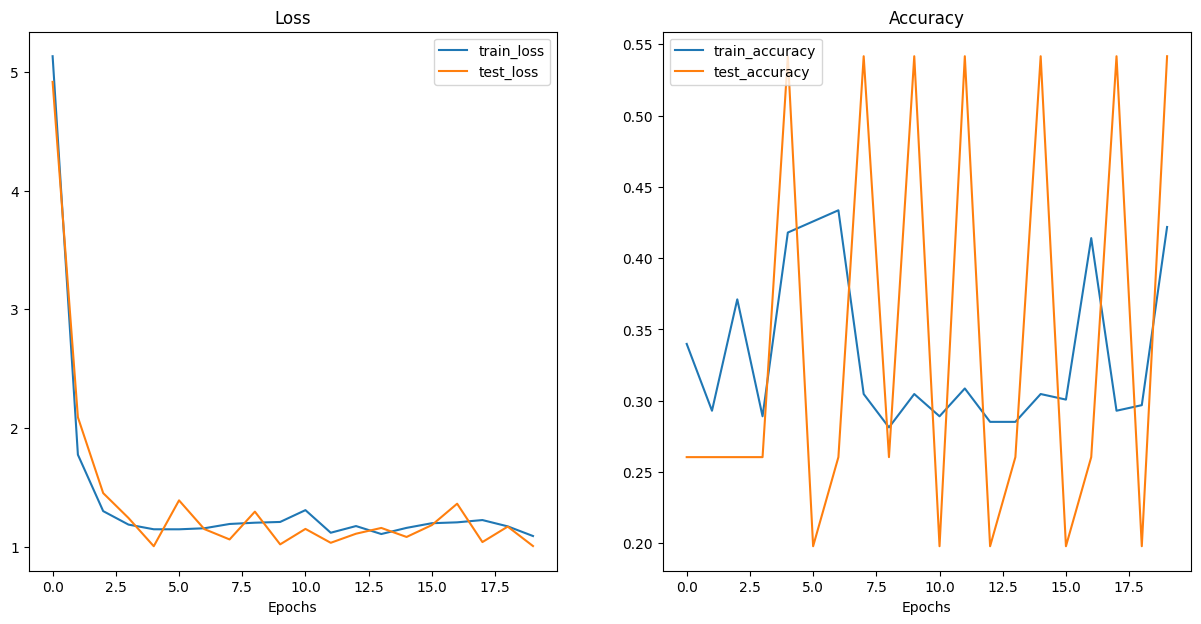

In [48]:
from going_modular.helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

These results are likely because of the difference in data resources and training regime of our ViT model versus the ViT paper. **Our model is severely underfitting**

# 11. Using pre-trained model from torchvision.models

In [49]:
#1. Get the pretrained weights of ViT-Base model
pre_trained_vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT

#2. Setup Vit model instance with pretrained weights
pretrained_vit=torchvision.models.vit_b_16(weights=pre_trained_vit_weights).to(device)

#3. Freeze the base parameters
for parameters in pretrained_vit.parameters():
  parameters.requires_grad=False

set_seeds()

pretrained_vit.heads=nn.Linear(in_features=768,out_features=len(class_names)).to(device)

pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:46<00:00, 7.51MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [50]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [51]:
from going_modular.helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/HarshEkbote/PyTorch-Basics/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [53]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [54]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pre_trained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [59]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloader(train_dir=train_dir,
                              test_dir=test_dir,
                              transform=pretrained_vit_transforms,
                              batch_size=32)

In [60]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [01:20<12:08, 80.90s/it]

Epoch: 1 | train_loss: 0.7663 |train_acc: 0.72 | test_loss: 0.5435 | test_acc: 0.88


 20%|██        | 2/10 [02:45<11:05, 83.21s/it]

Epoch: 2 | train_loss: 0.3436 |train_acc: 0.95 | test_loss: 0.3257 | test_acc: 0.90


 30%|███       | 3/10 [04:16<10:05, 86.57s/it]

Epoch: 3 | train_loss: 0.2068 |train_acc: 0.95 | test_loss: 0.2698 | test_acc: 0.92


 40%|████      | 4/10 [06:25<10:19, 103.29s/it]

Epoch: 4 | train_loss: 0.1557 |train_acc: 0.96 | test_loss: 0.2414 | test_acc: 0.92


 50%|█████     | 5/10 [08:23<09:04, 108.81s/it]

Epoch: 5 | train_loss: 0.1244 |train_acc: 0.97 | test_loss: 0.2271 | test_acc: 0.90


 60%|██████    | 6/10 [10:08<07:09, 107.34s/it]

Epoch: 6 | train_loss: 0.1210 |train_acc: 0.98 | test_loss: 0.2122 | test_acc: 0.93


 70%|███████   | 7/10 [11:53<05:19, 106.49s/it]

Epoch: 7 | train_loss: 0.0933 |train_acc: 0.98 | test_loss: 0.2342 | test_acc: 0.89


 80%|████████  | 8/10 [13:31<03:27, 103.87s/it]

Epoch: 8 | train_loss: 0.0793 |train_acc: 0.98 | test_loss: 0.2268 | test_acc: 0.91


 90%|█████████ | 9/10 [15:10<01:42, 102.46s/it]

Epoch: 9 | train_loss: 0.1084 |train_acc: 0.99 | test_loss: 0.2064 | test_acc: 0.94


100%|██████████| 10/10 [16:47<00:00, 100.71s/it]

Epoch: 10 | train_loss: 0.0646 |train_acc: 0.99 | test_loss: 0.1795 | test_acc: 0.92


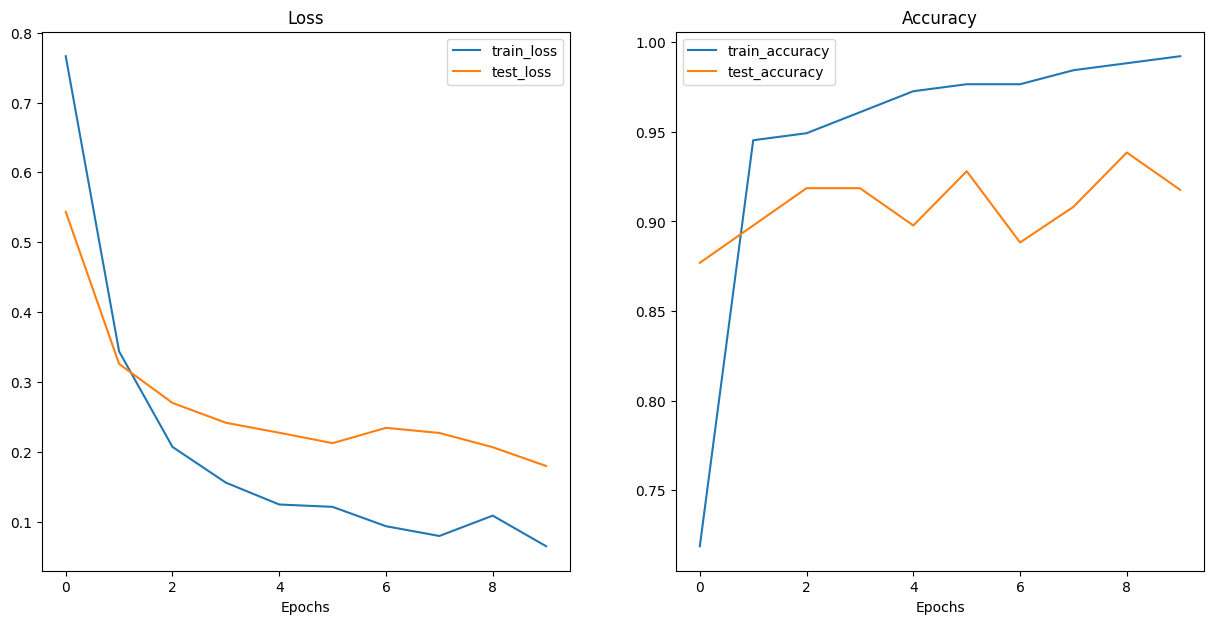

In [62]:
# Plot the loss curves
from going_modular.helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [63]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] model saving to models\09_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [66]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB
